<a href="https://colab.research.google.com/github/YaoYinYing/PPRCODE_Guideline/blob/master/PPRCODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PPRCODE on Colab 
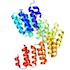

This is a experimentally reimplement work created by Yinying Yao.

Original webserver (MAY not work): [PPRCODE - Yin Lab](http://yinlab.hzau.edu.cn/pprcode/)

**If you find this tool useful to your research, please cite the following**:

- Junjie Yan, Yinying Yao, Sixing Hong, Yan Yang, Cuicui Shen, Qunxia Zhang, Delin Zhang, Tingting Zou, Ping Yin; Delineation of pentatricopeptide repeat codes for target RNA prediction, Nucleic Acids Research. PMID:30753696 DOI: 10.1093/nar/gkz075




In [1]:
#@title Install packages
#@markdown First, click the _Play Button_ ▶️ of the cell to start a new colab session and install required packages.
import os
import glob
import pathlib
import sys
import time
import traceback
import pickle
import re
from IPython.utils import io
import subprocess
import tqdm.notebook
import tempfile
import pandas as pd

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

BENCHMARK_DATA='https://raw.githubusercontent.com/YaoYinYing/PPRCODE_Guideline/master/ATPPR.fasta'

# PS_scan setting
PROSITE_URL='https://ftp.expasy.org/databases/prosite/'
PS_SCAN_URL='https://ftp.expasy.org/databases/prosite/ps_scan/ps_scan_linux_x86_elf.tar.gz'
PS_MOTIF='PS51375'

# PPRfinder setting
# Yinying build a copy
PPRFINDER_BUILD='https://raw.githubusercontent.com/YaoYinYing/PPRfinder/master/out/production/PPRfinder/PPRfinder.jar'
HMM_PROFILE_URL='https://raw.githubusercontent.com/YaoYinYing/PPRfinder/master/data/'
JDK_VER='openjdk-17-jdk-headless'
HMMER_VERSION='3.3.2'
HMMER_SRC_URL=f'http://eddylab.org/software/hmmer/hmmer-{HMMER_VERSION}.tar.gz'

TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'




TMP_DIR = "tmp"
JOBS_DIR='jobs'
RES_DIR='results'

# PS_SCAN zone
RES_DIR_SCAN=f"{RES_DIR}/scan"

# PPRfinder zone
RES_DIR_FIND=f'{RES_DIR}/find'

# the common result zone
RES_DIR_PICKLE=f'{RES_DIR}/pickle'
RES_DIR_REPORT=f'{RES_DIR}/report'
RES_DIR_FEATURE=f'{RES_DIR}/feature'
RES_DIR_FIGURE=f'{RES_DIR}/figure'

# conda path
CONDA_PATH='/opt/miniconda'

# if not already installed
total = 11
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for dir in [TMP_DIR,JOBS_DIR,RES_DIR,RES_DIR_SCAN,RES_DIR_FIND,RES_DIR_PICKLE,RES_DIR_REPORT,RES_DIR_FEATURE,RES_DIR_FIGURE]:
    os.makedirs(dir, exist_ok=True)
  pbar.update(2)
  os.system(f"wget -qnc {PS_SCAN_URL} -P {TMP_DIR}")
  pbar.update(1)

  # binaries setup
  os.system(f'mkdir {TMP_DIR}/bin && cd {TMP_DIR}/bin && tar zxf ../ps_scan_linux_x86_elf.tar.gz')
  os.system(f"wget -qnc {PPRFINDER_BUILD} -P {TMP_DIR}/bin")
  
  # HMMER compilation
  # /usr/local/bin/hmmsearch
  os.system(f'wget -qnc {HMMER_SRC_URL} -P {TMP_DIR}')
  os.system(f'cd {TMP_DIR}/bin && tar xvzf ../$(basename "{HMMER_SRC_URL}") && cd hmmer-{HMMER_VERSION} && ./configure --prefix=/usr/local/ && make -j 2 && make install')
  pbar.update(1)

  # setup conda
  os.system(f'if [ ! -f {TMP_DIR}/CONDA_READY ]; then  wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh; bash Miniconda3-latest-Linux-x86_64.sh -bfp {CONDA_PATH} 2>&1 1>/dev/null; rm Miniconda3-latest-Linux-x86_64.sh; touch {TMP_DIR}/CONDA_READY; fi')
  pbar.update(1)

  # conda env
  os.system(f'conda install -y  python -c plotly plotly-orca')
  pbar.update(1)

  # profiles 
  os.system(f'mkdir {TMP_DIR}/profiles')
  

  for p in ['profile.txt','prosite.dat','prorule.dat','evaluator.dat']:
    os.system(f"wget -qnc {PROSITE_URL}{p} -P {TMP_DIR}/profiles/")
  pbar.update(1)

  for p in ['morf.hmm','dyw_kp.hmm','dyw.hmm','all_PPR.hmm']:
    os.system(f"wget -qnc {HMM_PROFILE_URL}{p} -P {TMP_DIR}/profiles/")
  pbar.update(1)

  # packages  
  try:
    from Bio import SeqIO, Seq
  except:
    os.system(f"pip3 install biopython")
    os.system(f"pip3 install dna_features_viewer")
    os.system(f"pip3 install xlsxwriter")
    import xlsxwriter as xw
    from dna_features_viewer import GraphicFeature, GraphicRecord
    from Bio import SeqIO,Seq
  pbar.update(1)

  # JDK for PPRfinder https://github.com/ian-small/PPRfinder
  os.system(f"apt install -y {JDK_VER}")
  pbar.update(1)

  # add PATHs
  pths=[f"{pathlib.Path(TMP_DIR).resolve()}/bin/ps_scan/",f"{pathlib.Path(TMP_DIR).resolve()}/bin/"]
  for p in pths:
    if p  not in os.environ['PATH']:
      os.environ['PATH'] += f":{p}"
  pbar.update(1)

# updated at 2018/12/20 for pulication, experimentally validated.
code2rna_multi = {"ND": "U>C>G", "NN": "C>U", "TD": "G>A>U", "SD": "G>>C", "TN": "A>G", "SN": "A", "NS": "C>U>A",
                  "NT": "C>U", "GN": "A>C", "TS": "A>G", "GD": "G", "TT": "A>G", "RD": "-", "SS": "A", "AD": "G",
                  "KD": "-", "ST": "A", "NE": "U>C", "DS": "-", "CD": "G", "DD": "-", "NG": "C>U>A", "AN": "A>>U",
                  "GS": "-", "ES": "-", "LD": "-", "SG": "A>G", "GT": "C", "HD": "-", "CN": "A>>G", "VD": "G",
                  "ID": "-", "SE": "-", "NC": "U>C>>A", "AS": "-", "RS": "-", "MD": "-", "NK": "C>U", "NL": "C",
                  "DT": "-", "RN": "-", "TG": "A>>G", "GG": "-", "LN": "-", "LS": "-", "VN": "A", "TE": "G", "SP": "-",
                  "KN": "C>U", "NR": "-", "DN": "C", "CS": "A", "QD": "-", "NV": "C>U", "ED": "-", "IN": "-",
                  "VS": "-", "HN": "-", "AT": "-", "NH": "U>C", "AG": "-", "NI": "C", }

def ps_scan(f,s):
  
    if debug: print(s.id)
    sequence_=s
    #print(sequence_)
    ps_out_file=f"{RES_DIR_SCAN}/{s.id}_PPR_PSSCAN_pff.log"
    cmd=f"perl {pathlib.Path(TMP_DIR).resolve()}/bin/ps_scan/ps_scan.pl -e {s.id} -p {PS_MOTIF} -o pff -d {pathlib.Path(TMP_DIR).resolve()}/profiles/prosite.dat {f} | sort -n -k 2 > {ps_out_file}"
    os.system(cmd)
    ps_out_file_scan=f"{RES_DIR_SCAN}/{s.id}_PPR_PSSCAN_scan.log"
    cmd=f"perl {pathlib.Path(TMP_DIR).resolve()}/bin/ps_scan/ps_scan.pl -e {s.id} -p {PS_MOTIF} -o scan -d {pathlib.Path(TMP_DIR).resolve()}/profiles/prosite.dat {f} | sort -n -k 2 > {ps_out_file_scan}"
    os.system(cmd)
    try:
        
        result_response_pff=open(ps_out_file,'r').read()
        matchpos = re.findall(r'(\d+)\t(\d+)\t%s' % PS_MOTIF, result_response_pff)
        #print(matchpos)
        refinedpos = [[], []]

        # print(matchpos)
        match_motif = []

        # get original match motifs
        for pos in matchpos:
            mypos=sequence_[int(pos[0])-1:int(pos[1])]
            mypos.id=f'{s.id}_{int(pos[0])-1}_{pos[1]}'
            #print(mypos)
            match_motif.append(mypos)

        #print(match_motif)
        # find the motif sequence deletion by ProSite and refine the positions
        
        result_response_scan=open(ps_out_file_scan,'r').read()
        for origin_motif, origin_pos in zip([str(x.seq) for x in match_motif], matchpos):
            try:
                if debug: print(origin_motif)
                if fix_gap: 
                  motif_delete_find = re.findall(r'' + origin_motif + '(-+)', result_response_scan)[0]
                else:
                  motif_delete_find=''
                if debug: print("orginal Motif= %s\t motif deletion=%s\t deletion length=%s" % (origin_motif, motif_delete_find,len(motif_delete_find)))
                refinedpos[0].append(int(origin_pos[0]))

                # V1.3.1 solve the motif boundary overlap
                if (len(refinedpos[1]) > 0 and refinedpos[1][-1] > refinedpos[0][-1]):
                    if debug: print("==>refine pos 0 = %s\t refine pos 1 = %s" % (refinedpos[0][-1], refinedpos[1][-1]))
                    refinedpos[1][-1] = refinedpos[0][-1]
                    if debug: print("-->refine pos 0 = %s\t refine pos 1 = %s" % (refinedpos[0][-1], refinedpos[1][-1]))


                refinedpos[1].append(int(origin_pos[1]) + 1 + len(motif_delete_find))

            except Exception as e:
                #traceback.print_exc()
                #if debug: print("orginal Motif= %s\t motif deletion=%s" % (origin_motif, "deletion not found."))
                refinedpos[0].append(int(origin_pos[0]))
                refinedpos[1].append(int(origin_pos[1]) + 1)



        # the second round of refinement of position: the conserved "P" and the 36 aa length motif  # the conserved "P" label is based on weblogo results
        # Eureka!
        refindpos_end_2nd = []
        try:
            pos_index = 0
            for refinedpos_start_slide, refinedpos_end_slide in zip(refinedpos[0], refinedpos[1]):
                if debug: print("refined pos[%s]: %s -> %s " % (
                    pos_index, refinedpos_start_slide, refinedpos_end_slide))
                if debug: print(sequence[refinedpos_start_slide:refinedpos_end_slide])
                if debug: print("Scanning the %s/%s motif..." % (pos_index + 1, refinedpos[0].__len__()))
                if pos_index < (refinedpos[0].__len__() - 1):
                    try:
                      if (refinedpos[0][pos_index + 1] - refinedpos[1][
                          pos_index] == 1 and
                              sequence[refinedpos_start_slide:refinedpos_end_slide][-1] == "P"):
                          if debug: print("Find P!")
                          if debug: print(len(sequence[refinedpos_start_slide:refinedpos_end_slide]))
                          if debug: print(sequence[refinedpos_start_slide:refinedpos_end_slide][-1])
                          refindpos_end_2nd.append(refinedpos_end_slide + 1)
                          pass
                      else:
                          # print("No P find!")
                          refindpos_end_2nd.append(refinedpos_end_slide)
                    except:
                        refindpos_end_2nd.append(refinedpos_end_slide)
                elif pos_index == (refinedpos[0].__len__() - 1):
                    if sequence[refinedpos_start_slide:refinedpos_end_slide][-1] == "P":
                        if debug: print("Find P in the last motif...")
                        if debug: print(len(sequence[refinedpos_start_slide:refinedpos_end_slide]))
                        if debug: print(sequence[refinedpos_start_slide:refinedpos_end_slide][-1])
                        refindpos_end_2nd.append(refinedpos_end_slide + 1)

                    else:
                        if debug: print("No P find in the last motif...")
                        refindpos_end_2nd.append(refinedpos_end_slide)
                pos_index += 1



        except Exception as e:
            print("Oops! Something wrong hanpens with the following sequence!")
            print(f"--->{s.id}")
            traceback.print_exc() if debug else print(e)
        finally:
            if debug: print(refindpos_end_2nd)

        # print(match_motif)
        # print(refinedpos)

        # extract motifs scores according to the match positions
        motif_score = []
        
        for line in open(ps_out_file,'r'):
          motif_score.append(float(line.split("\t")[-2]))
        # print(motif_score)
        parsed_ppr=[]
        for pos_start,pos_end,score in zip(refinedpos[0], refindpos_end_2nd,motif_score):
            mypos=sequence_[pos_start:pos_end]
            mypos.id=f'{s.id}'
            mypos.annotations={
                "PS_SCORE"      :   score,
                "PPR_STARTS"    :   pos_start+1,
                "PPR_ENDS"      :   pos_end,
                "FIFTH_AA"      :   sequence_[pos_start+4],
                "LAST_AA"       :   sequence_[pos_end-1],
                "PPR_CODE"      :   sequence_[pos_start+4]+sequence_[pos_end-1],
                "RNA_BASE"      :   code2rna_multi[sequence_[pos_start+4]+sequence_[pos_end-1]] if sequence_[pos_start+4]+sequence_[pos_end-1] in code2rna_multi.keys() else '?',
                               }
            parsed_ppr.append(mypos)
            
        return parsed_ppr
    except Exception as e:
        print("Oops! Something wrong hanpens with the following sequence!")
        print(f"--->{s.id}")
        traceback.print_exc() if debug else print(e)

def pprfinder(f,s):
  if debug: print(s.id)
  sequence_=s
  with  tempfile.NamedTemporaryFile(suffix=f'_{s.id}.fasta',delete=True) as tmp_fasta_file:
    SeqIO.write(s, tmp_fasta_file.name, "fasta")

    #run scanning
    hmmsearch_out_file=pathlib.Path(f"{RES_DIR_FIND}/{s.id}_PPR_HMMSEARCH.domt").resolve()

    # recommended setting from Small's Lab. see https://github.com/ian-small/OneKP
    cmd_1=f"hmmsearch --domtblout {hmmsearch_out_file} --noali -E 0.1 --cpu 2 {TMP_DIR}/profiles/all_PPR.hmm {tmp_fasta_file.name}"
    os.system(cmd_1)
    cmd_2=f"java -jar {pathlib.Path(TMP_DIR).resolve()}/bin/PPRfinder.jar {tmp_fasta_file.name} {pathlib.Path(hmmsearch_out_file).resolve()}"
    os.system(cmd_2)

    # expected output: f'{}{s.id}_PPR_HMMSEARCH.domt_motifs.txt'}
    ppr_df=pd.read_table(f'{RES_DIR_FIND}/{s.id}_PPR_HMMSEARCH.domt_motifs.txt',names=['id','start','end','score', 'motif_seq','second','fifth_aa','last_aa','motif_type'])
    #print(ppr_df)
    parsed_ppr=[]
    for pos_start,pos_end,score,motif_type,fifth,last,motif_seq in zip(ppr_df.start, ppr_df.end,ppr_df.score,ppr_df.motif_type,ppr_df.fifth_aa,ppr_df.last_aa,ppr_df.motif_seq):
      mypos=sequence_[pos_start:pos_end]
      mypos.id=f'{s.id}'
      mypos.annotations={
        "PPR_TYPE"      :   motif_type,
        "PS_SCORE"      :   score,
        "PPR_STARTS"    :   pos_start,
        "PPR_ENDS"      :   pos_end,
        "FIFTH_AA"      :   fifth,
        "LAST_AA"       :   last,
        "PPR_CODE"      :   fifth+last,
        "RNA_BASE"      :   code2rna_multi[fifth+last] if fifth+last in code2rna_multi.keys() else '?',
                               }
      parsed_ppr.append(mypos)
            
  return parsed_ppr

  0%|          | 0/11 [elapsed: 00:00 remaining: ?]

In [2]:
#@title Paste/Upload the amino acid sequences to predict ⬇️
import glob

# define sequence
#@markdown For one single sequence: 
jobname = "ZmPPR10" #@param {type:"string"}
sequence = 'MEATGRGLFPNKPTLPAGPRKRGPLLPAAPPPPSPSSLPLDSLLLHLTAPAPAPAPAPRRSHQTPTPPHSFLSPDAQVLVLAISSHPLPTLAAFLASRRDELLRADITSLLKALELSGHWEWALALLRWAGKEGAADASALEMVVRALGREGQHDAVCALLDETPLPPGSRLDVRAYTTVLHALSRAGRYERALELFAELRRQGVAPTLVTYNVVLDVYGRMGRSWPRIVALLDEMRAAGVEPDGFTASTVIAACCRDGLVDEAVAFFEDLKARGHAPCVVTYNALLQVFGKAGNYTEALRVLGEMEQNGCQPDAVTYNELAGTYARAGFFEEAARCLDTMASKGLLPNAFTYNTVMTAYGNVGKVDEALALFDQMKKTGFVPNVNTYNLVLGMLGKKSRFTVMLEMLGEMSRSGCTPNRVTWNTMLAVCGKRGMEDYVTRVLEGMRSCGVELSRDTYNTLIAAYGRCGSRTNAFKMYNEMTSAGFTPCITTYNALLNVLSRQGDWSTAQSIVSKMRTKGFKPNEQSYSLLLQCYAKGGNVAGIAAIENEVYGSGAVFPSWVILRTLVIANFKCRRLDGMETAFQEVKARGYNPDLVIFNSMLSIYAKNGMYSKATEVFDSIKRSGLSPDLITYNSLMDMYAKCSESWEAEKILNQLKCSQTMKPDVVSYNTVINGFCKQGLVKEAQRVLSEMVADGMAPCAVTYHTLVGGYSSLEMFSEAREVIGYMVQHGLKPMELTYRRVVESYCRAKRFEEARGFLSEVSETDLDFDKKALEAYIEDAQFGR' #@param {type:"string"}
sequence=sequence.upper()
#@markdown ---

#@markdown OR upload your multiple sequences in FASTA format to apply batch processing: 

#@markdown Click the icon like a folder 📁 on left panel, upload your own file into a subfolder named **jobs**.

#@markdown After uploading is over, you must keep the `only_process_my_fasta` checked and click the _Play Button_ ▶️ on each cell to continue the processing.

find_ppr_by='PS_Scan (Default)' #@param ['PS_Scan (Default)','PPRfinder (Small\'s Lab)']
only_process_my_fasta = False #@param {type:"boolean"}
run_benchmark = False #@param {type:"boolean"}
#@markdown - `find_ppr_by` - Choose a proper algorithm to process your sequence. PPRCODE use PS_Scan by default. However, you may use PPRfinder from Small's Lab.
#@markdown - `only_process_my_fasta` - Analyse uploaded files. **This will ignore any input in boxes above.**
#@markdown - `run_benchmark` - Fetch a benchmark dataset. **This could make your job running messy**
#@markdown ---

if find_ppr_by.startswith('PS_Scan'):
  program='PS_Scan'
elif find_ppr_by.startswith('PPRfinder'):
  program='PPRfinder'


#@markdown Output settings

generate_excel_report=True #@param {type:"boolean"}
download_full_report=True #@param {type:"boolean"}

plot_ppr=True #@param {type:"boolean"}
plot_rna=True #@param {type:"boolean"}
plot_score = False #@param {type:"boolean"}
plot_edge = True #@param {type:"boolean"}
plot_type = True #@param {type:"boolean"}
plot_color_scheme='RdBu' #@param ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean'] {type:"string"}

#@markdown - `generate_excel_report` - Generate a human-friendly report file in xlsx format
#@markdown - `download_full_report` - Once the processing is finished, the full result will be zipped and downloaded automatically.
#@markdown - `plot_ppr` - Plot PPR motifs, colored by normalized PS_SCAN score
#@markdown - `plot_rna` - Plot PPR motifs w/ RNA base, colored by normalized PS_SCAN score. **DISABLED when benchmark is running.**
#@markdown - `plot_score` - Plot and color PPR motifs by normalized PS_SCAN score. **DISABLED when benchmark is running.**
#@markdown - `plot_edge` - Plot edges of each PPR motifs, colored by normalized PS_SCAN score. **DISABLED when benchmark is running.**
#@markdown - `plot_type` - Plot motif type of each PPR motifs, colored by normalized PS_SCAN score. **DISABLED when benchmark is running.**

#@markdown - `plot_color_scheme` - Color scheme used in plots.

#@markdown ---
debug = False #@param {type:"boolean"}
#@markdown - `debug` - Some debug messages

#@markdown ---
#@markdown Experimental (manually correction to scan results)

fix_gap = False #@param {type:"boolean"}
#@markdown - `fix_gap` - Fix gap in sequence scanning results. Turn it off so that the results will not be weird.
if run_benchmark:
  
  plot_rna = False
  plot_score = False
  plot_edge = False
  plot_type = False
  os.system(f"wget -qnc {BENCHMARK_DATA} -P {JOBS_DIR}/")



if not only_process_my_fasta:
  open(f"./{JOBS_DIR}/{jobname}.fasta",'w').write(f'>{jobname}\n{sequence}')
else:
  if len(glob.glob(f'{JOBS_DIR}/*.fasta'))==0:
    raise FileNotFoundError("NO FASTA file is found!")


In [3]:
#@title Process the FASTAs
#@markdown Click the _Play Button_ to process your data.
fastas=glob.glob(f'{JOBS_DIR}/*.fasta')
if debug: print(fastas)

job_list=[s for f in fastas for s in SeqIO.parse(f,'fasta') ]
if debug: print(len(job_list))
total=len(job_list)

with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  for f in fastas:
    for s in SeqIO.parse(f,'fasta'):
      if program=='PS_Scan':
        ppr=ps_scan(f,s)
      elif program=='PPRfinder':
        ppr=pprfinder(f,s)
      else:
        raise ValueError('What do you want me to do haiyaaaah?')

      pickle.dump(ppr,open(f'{RES_DIR_PICKLE}/{s.id}.pkl','wb'))
      pbar.update(1)

  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

score minima: 5.031
score maxima: 14.096


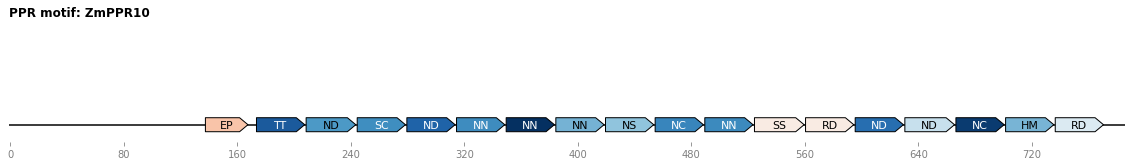

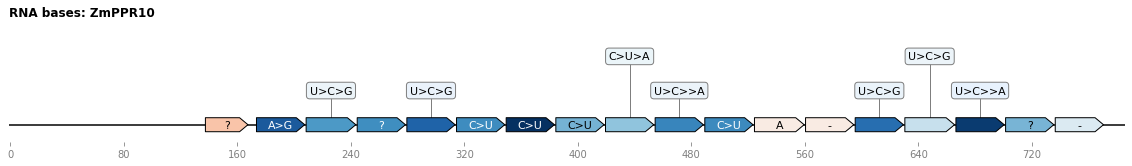

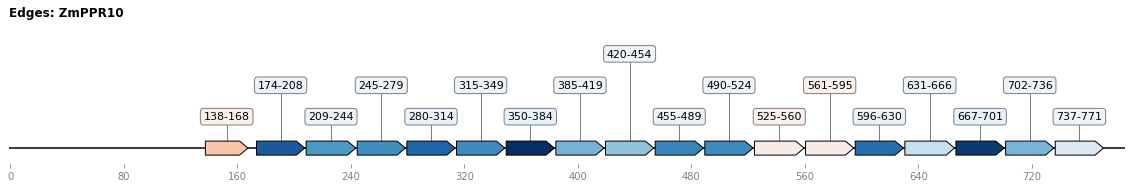

In [4]:
#@title Plot PPRs
#@markdown Click the _Play Button_ to plot your results.
fixed_plot_width = 20 #@param {type:"slider", min:0, max:200, step:10}

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

color_scale = 0 #@param {type:"slider", min:0, max:50, step:5}

viridis = cm.get_cmap(plot_color_scheme)

def draw_ppr(s,ppr):
  features=[
      GraphicFeature(start=a, end=b, color=viridis(float(c/color_scale)),strand=+1,
                    label=d) for p in ppr for a,b,c,d in zip([p.annotations["PPR_STARTS"]],[p.annotations["PPR_ENDS"]],[p.annotations["PS_SCORE"]],[p.annotations["PPR_CODE"]])
  ]
  record = GraphicRecord(sequence_length=len(s.seq), features=features)
  ax, _ =record.plot(figure_width=fixed_plot_width if fixed_plot_width != 0 else len(s.seq)/20)
  ax.set_title(f"PPR motif: {s.id}", loc='left', weight='bold')
  ax.figure.savefig(f'{RES_DIR_FIGURE}/PPR-{s.id}.png')

def draw_rna(s,ppr):
  features=[
      GraphicFeature(start=a, end=b, color=viridis(float(c/color_scale)),strand=+1,
                    label=d) for p in ppr for a,b,c,d in zip([p.annotations["PPR_STARTS"]],[p.annotations["PPR_ENDS"]],[p.annotations["PS_SCORE"]],[p.annotations["RNA_BASE"]])
  ]
  record = GraphicRecord(sequence_length=len(s.seq), features=features)
  ax, _ =record.plot(figure_width=fixed_plot_width if fixed_plot_width != 0 else len(s.seq)/20)
  ax.set_title(f"RNA bases: {s.id}", loc='left', weight='bold')
  ax.figure.savefig(f'{RES_DIR_FIGURE}/RNA-{s.id}.png')

def draw_score(s,ppr):
  features=[
      GraphicFeature(start=a, end=b, color=viridis(float(c/color_scale)),strand=+1,
                    label=str(d)) for p in ppr for a,b,c,d in zip([p.annotations["PPR_STARTS"]],[p.annotations["PPR_ENDS"]],[p.annotations["PS_SCORE"]],[p.annotations["PS_SCORE"]])
  ]
  record = GraphicRecord(sequence_length=len(s.seq), features=features)
  ax, _ =record.plot(figure_width=fixed_plot_width if fixed_plot_width != 0 else len(s.seq)/20)
  ax.set_title(f"PS scan scores: {s.id}", loc='left', weight='bold')
  ax.figure.savefig(f'{RES_DIR_FIGURE}/Scores-{s.id}.png')

def draw_type(s,ppr):
  features=[
      GraphicFeature(start=a, end=b, color=viridis(float(c/color_scale)),strand=+1,
                    label=str(d)) for p in ppr for a,b,c,d in zip([p.annotations["PPR_STARTS"]],[p.annotations["PPR_ENDS"]],[p.annotations["PS_SCORE"]],[p.annotations["PPR_TYPE"]])
  ]
  record = GraphicRecord(sequence_length=len(s.seq), features=features)
  ax, _ =record.plot(figure_width=fixed_plot_width if fixed_plot_width != 0 else len(s.seq)/20)
  ax.set_title(f"PS scan scores: {s.id}", loc='left', weight='bold')
  ax.figure.savefig(f'{RES_DIR_FIGURE}/Type-{s.id}.png')

def draw_edge(s,ppr):
  features=[
      GraphicFeature(start=a, end=b, color=viridis(float(c/color_scale)),strand=+1,
                    label="-".join([str(a),str(b)])) for p in ppr for a,b,c in zip([p.annotations["PPR_STARTS"]],[p.annotations["PPR_ENDS"]],[p.annotations["PS_SCORE"]])
  ]
  record = GraphicRecord(sequence_length=len(s.seq), features=features)
  ax, _ =record.plot(figure_width=fixed_plot_width if fixed_plot_width != 0 else len(s.seq)/20)
  ax.set_title(f"Edges: {s.id}", loc='left', weight='bold')
  ax.figure.savefig(f'{RES_DIR_FIGURE}/Edges-{s.id}.png')

total=len(job_list)

with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:

  pkls_files=glob.glob(f'{RES_DIR_PICKLE}/*.pkl')
  pkls={pathlib.Path(x).stem: x for x in pkls_files}
  fastas=glob.glob(f'{JOBS_DIR}/*.fasta')
  job_list={s.id:s for f in fastas for s in SeqIO.parse(f,'fasta') }
  
  scores=[]
  for s in job_list.keys():
    data = pickle.load(open(f'{RES_DIR_PICKLE}/{s}.pkl','rb'))
    scores+=[sc for p in data for sc in  [p.annotations["PS_SCORE"]]]
  print(f'score minima: {min(scores)}')
  print(f'score maxima: {max(scores)}')
  if color_scale==0:color_scale=max(scores)

  for s in job_list.keys():
    data = pickle.load(open(f'{RES_DIR_PICKLE}/{s}.pkl','rb'))
    #print(s)
    try:
      if plot_ppr: draw_ppr(job_list[s],data)
      if plot_rna: draw_rna(job_list[s],data)
      if plot_score: draw_score(job_list[s],data)
      if plot_edge: draw_edge(job_list[s],data)
      if plot_type and program=='PPRfinder': draw_type(job_list[s],data)
    except Exception as e:
      traceback.print_exc() if debug else print(e)
    finally:
      pbar.update(1)


In [5]:
#@title Generate report and download it!
#@markdown Click the _Play Button_ to generate result in `xlsx` format
def generate_full_report():
  
  pkls_files=glob.glob(f'{RES_DIR_PICKLE}/*.pkl')
  process_id = time.strftime("%Y%m%d_%H%M%S", time.localtime())
  xlsx_filename = f"{RES_DIR_REPORT}/PPRCODE_RESULTS_{process_id}.xlsx" 
  test_book = xw.Workbook(xlsx_filename)

  # set workbook property
  test_book.set_properties({
                'title': 'PPRCODE PREDICTION',
                'subject': 'http://yinlab.hzau.edu.cn/pprcode/',
                'author': 'PPRCODE project',
                'manager': 'Yan et al.',
                'company': 'Yin Lab',
                'comments': 'Created with pprcode project.'})

  total=len(pkls_files)
  with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
    for pf in pkls_files:
      try:
        data = pickle.load(open(pf,'rb'))
        motif_starts  = [x.annotations[  "PPR_STARTS"   ] for x in data]
        motif_ends    = [x.annotations[  "PPR_ENDS"     ] for x in data]
        motif_sequence= [str(x.seq) for x in data]
        fifth_code    = [x.annotations[  "FIFTH_AA"     ] for x in data]
        last_code     = [x.annotations[  "LAST_AA"      ] for x in data]
        ppr_code      = [x.annotations[  "PPR_CODE"     ] for x in data]
        rna_base      = [x.annotations[  "RNA_BASE"     ] for x in data]
        motif_length  = [len(str(x.seq)) for x in data]
        motif_score   = [x.annotations[  "PS_SCORE"     ] for x in data]
        motif_type    = [x.annotations[  "PPR_TYPE"     ] for x in data] if program=='PPRfinder' else ['' for x in data]
        data_list=[[a,b,c,d,e,f,g,h,i,j] 
               for a,b,c,d,e,f,g,h,i,j in zip(
                   motif_starts,
                   motif_ends,
                   motif_sequence,
                   fifth_code,
                   last_code,
                   ppr_code,
                   rna_base,
                   motif_length,
                   motif_score,
                   motif_type)]
        seq_id=pathlib.Path(pf).resolve().stem
        try:
          write_excel_tables(test_book,seq_id,data_list)
        except Exception as e:
          print("Oops! Something wrong hanpens when writing in to excel report!")
          print(seq_id)
          traceback.print_exc() if debug else print(e)
      except Exception as e:
        print("Oops! Something wrong hanpens when loading pickle file!")
        print(seq_id)
        traceback.print_exc() if debug else print(e)
      finally:
        pbar.update(1)
    print("All jobs are accomplished.")
    test_book.close()

def write_excel_tables(test_book, sequence_name, ppr_total_list_reversed):
    # reversed ppr code result list for making xlsx file

    code_count_result_name = "PPR motifs and PPR codes: %s" % sequence_name
    format_title = test_book.add_format()
    format_content = test_book.add_format()
    format_title.set_font("Times New Roman")
    format_title.set_font_size(11)
    format_title.set_bold()
    format_title.set_bottom(2)

    format_content.set_font("Times New Roman")
    format_content.set_font_size(11)
    sheet_name=sequence_name
    for c in "[]:*?/\\+@!^'{}()|#%&~`\"":
      sheet_name=sheet_name.replace(c,"_")
    worksheet = test_book.add_worksheet(sheet_name)
    worksheet.set_column(0, 1, 10)
    worksheet.set_column(2, 2, 50)
    worksheet.set_column(3, 8, 10)

    worksheet.write(0, 0, code_count_result_name, format_title)
    for n in range(1, 9):
        worksheet.write(0, n, "", format_title)
    worksheet.write(1, 0, "Motif Start", format_title)
    worksheet.write(1, 1, "Motif End", format_title)
    worksheet.write(1, 2, "Motif Sequence", format_title)
    worksheet.write(1, 3, "Fifth amino acid", format_title)
    worksheet.write(1, 4, "Last amino acid", format_title)
    worksheet.write(1, 5, "PPR code", format_title)
    worksheet.write(1, 6, "RNA base", format_title)
    worksheet.write(1, 7, "Motif Length", format_title)
    worksheet.write(1, 8, f"{program} Score" , format_title)
    if program=='PPRfinder':
      worksheet.write(1, 9, "Motif Type" , format_title) 
    row = 2
    col = 0

    rna = ""
    for ppr_list in ppr_total_list_reversed:
        # print(ppr_list)
        motif_start = ppr_list[0]
        motif_end = ppr_list[1]
        motif_sequence = ppr_list[2]
        fifth_code = ppr_list[3]
        last_code = ppr_list[4]
        ppr_code = ppr_list[5]
        rna_base = ppr_list[6]

        rna = ''.join([rna, " (", rna_base, ")"])

        motif_length = ppr_list[7]
        motif_score = ppr_list[8]
        if program=='PPRfinder':
          motif_type = ppr_list[9] 

        worksheet.write(row, col, motif_start, format_content)
        worksheet.write(row, col + 1, motif_end, format_content)
        worksheet.write(row, col + 2, motif_sequence, format_content)
        worksheet.write(row, col + 3, fifth_code, format_content)
        worksheet.write(row, col + 4, last_code, format_content)
        worksheet.write(row, col + 5, ppr_code, format_content)
        worksheet.write(row, col + 6, rna_base, format_content)
        worksheet.write(row, col + 7, motif_length, format_content)
        worksheet.write(row, col + 8, motif_score, format_content)
        if program=='PPRfinder':
          worksheet.write(row, col + 9, motif_type, format_content) 
        row += 1
        pass
    worksheet.write(row + 1, col, "The RNA predicted by this PPR sequence:", format_title)
    worksheet.write(row + 2, col, rna, format_title)
    worksheet.write(row + 4, col, "Notes:", format_title)
    worksheet.write(row + 5, col,
                    "'-' represents no correlated RNA bases for this PPR code identified by biochemical assays (EMSA, ITC);",
                    format_content)
    worksheet.write(row + 6, col,
                    "'?' represents unknown bases, as no biochemical assays have been performed to identify the correlated RNA bases for the PPR code.",
                    format_content)
    worksheet.write(row + 8, col, "If you find this tool useful to your research, please cite the following:",
                    format_title)
    worksheet.write(row + 9, col,
                    "Junjie Yan, Yinying Yao, Sixing Hong, Yan Yang, Cuicui Shen, Qunxia Zhang, Delin Zhang, Tingting Zou, Ping Yin; Delineation of pentatricopeptide repeat codes for target RNA prediction, Nucleic Acids Research, gkz075, https://doi.org/10.1093/nar/gkz075",
                    format_content)
    worksheet.write(row + 11, col, "Copyright: Yin lab", format_title)
    pass


if generate_excel_report: 
  generate_full_report()

zipped=f'PPRCODE_{time.strftime("%Y%m%d_%H%M%S", time.localtime())}.zip'
os.system(f"zip -FSr {zipped} {RES_DIR}")

if download_full_report:
  if IN_COLAB:
    files.download(f'{zipped}')
  else:
    print("this notebook appears to be running locally, to download click folder icon to the left, navigate to file, right click and download")



  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

All jobs are accomplished.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Acknowledgements



1.   [ColabFold](https://github.com/sokrypton/ColabFold) for fancy Colab codes.
2.   [DnaFeaturesViewer](https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer) for impressive plotting of sequences
3.   [Plotly](https://plotly.com/python) and [Plotly-Orca](https://github.com/plotly/orca) 
4.   [Matplotlib](https://matplotlib.org/index.html)
5.   [Prosite](https://ftp.expasy.org/databases/prosite) and [PS_Scan](https://ftp.expasy.org/databases/prosite/ps_scan/) program
6.   [Biopython](https://biopython.org/)
7.   [PPRfinder](https://github.com/ian-small/PPRfinder) 




# FAQ
*   I'm new here. How do I process my PPR protein using this Notebook?
  *   First of all, you need a Google account to get you logged in.
  *   Click the `Play Buttom` ▶ beside the first cell marking `Install packages` to start a new Colab session. If you are warned by a message like _**"This notebook was not authored by Google"**_ , please don't worry about it. Click `Run anyway` , then re-click that `Play Buttom` ▶ to go ahead.
  *   If you have only one sequence, just paste its **amino-acid** in the input box marking `sequence:` in the second cell. Don't forget naming your jobs running in `jobname:` box.
  *    Now find `Runtime` in `top menu bar` and hit `Run all` to execute the following cells to perform PPR processing, plotting, report generation and file downloading.
  *    After the processing is over, just feel free to close the browser tab directly.
*   I have handreds of thousands of sequences to process. How do I run a batch processing?
   *   First of all, you need a Google account to get you logged in.
   *   Click the `Play Buttom` ▶ beside the first cell marking `Install packages` to start a new Colab session. If you are warned by a message like _**"This notebook was not authored by Google"**_ , please don't worry about it. Click `Run anyway` , then re-click that `Play Buttom` ▶ to go ahead.
   *    Now you will find a icon like a folder 📁 on left side panel. Click it to check all your working directory.
   *    You will find a subfolder named `jobs`. Right-click it and upload your sequences file. Note that we only support [FASTA](https://www.ncbi.nlm.nih.gov/genbank/fastaformat/) format and the suffix should be `.fasta`. If anything werd hanppens, please check your file first.
   *    After uploading is over, please make sure the option `only_process_my_fasta:` is checked because we want to ignore the example data in these boxes.
   *    Still find `Runtime` in `top menu bar` and hit `Run all` to execute the following cells to perform PPR processing, plotting, report generation and file downloading.
   *    After the processing is over, just feel free to close the browser tab directly.
*   How do I re-initialize my working space?
  *   Still find `Runtime` in `top menu bar` and you will find `Factory rest runtime`. 
*   Does Colab install anything in my computer?
  * No, everything hanpens in Colab backend server. **Await is all you need.**
*  What is Colab? Do I need to pay for it?
   *  Please see [Colab FAQ document](https://research.google.com/colaboratory/faq.html)
   *  PPRCODE only uses the CPU resource of Colab. So it is definitely free-of-charge. **Please do not set `runtime` to `GPU` or `TPU` because neither of them will help at all.**
*  How long will the job running take?
   *   PPRCODE colab release has got much faster than orignal server because we use a copy of `PS_scan` program for local processing instead of webpage submission. For accurate timing of the running, please check the `progress bar` on each cell. 
*  I received some error messages, what should I do?
   * It doesn't matter if the processing is correct.
   * Meanwhile, please don't name your sequences with uncommon characters.
*  How should I share my feedback or report a bug?
   *  Please share your any feedback or report bugs as a issue on [GitHub](https://github.com/YaoYinYing/PPRCODE_Guideline/issues)
   *  Please do not send/reply anything to the email address of [original server](http://yinlab.hzau.edu.cn/pprcode/) because **no one** will dig around that inbox.
*  Why does the final report look a bit different from that of orginal server?
   *  In the program running on our original server, one of the options is enabled to make a _manual correction_ of `PS_scan` result. However, this is now disabled by default in Colab version as a experimental option `fix_gap:` so that you won't receive any odd result.
*  Can I run this jupyter notebook on my local machine?
   * Absolutely yes! If your are familiar with Python programming and basic Unix shell scripts, just have fun with it! But be aware that this notebook is written for linux only.